# Delay Tolerant Networks

### Description

In several instances, network communications can occur with relevant delays, as for extra-terrestial communications or for supervised monitoring networks. In such network deciding which node can communicate with which other node and when is extremely complicated issue (a np-completed scheduling problem).

### Assignments

1. Generate a series of patterns of transmissions on a network represented as a graph. In such graph the edges are weighted accordingly to the delay between transmittion and reception.
2. Implement euristic algorithms to lower the potential of the network, i.e. aiming at minimizing the distance of the communications from their final destination.
3. Find out the most efficient algorithm

### Contacts
Leonardo Badia <badia@dei.unipd.it>

# Introduction to Delay Tolerant Networks

Delay Tolerant Networking (DTN) is a relatively new area of research which 
is rapidly becoming the focus of considerable effort. DTN is an approach
to computer architecture that seeks to address the technical issues in 
heterogeneus networks that may lack continuos network connectivity. The
final aim of this developing study area is to tackle problems which the 
Internet is not able to face.  

There's a great variety among the different DTNs: they range from deep 
space networks to buses driving around mobile wireless hotspots in 
villages to provide Internet service to kiosks. 

The big difference from the regular Internet Protocol (IP) is that IP
assumes a seamless end-to-end data path instead DTNs are built to account
for errors and disconnections. Unlike IP, where heterogeneus networks are 
connected by assigning each node a common network-layer identifier (IP address),
a DTN uses "naming, layering, encapsulation and persistent storage".

The situations in which we use DTNs are pretty challenging:

* The throughput is generally low (we can think for instance about the acoustic in underwater modems) and may 
be highly asymmetric or in the worse scenario a return channel might not 
exist

* These networks are frequently disconnected, not only by faults but due
to motion for instance

* These systems frequently operate with a low duty cycle and the queuing 
time can be very large; with these conditions TCP would time out the session
instead UDP would lose all the packets.

In [1]:
#used to import the utility functions
import sys
sys.path.insert(1, "utility_functions/")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import math
import pylab as pl
from matplotlib import collections  as mc
from network_utilities import generate_network, plot_network, disable_links, adjacency_matrix
from greedy_routing import greedy_routing, DTN_dijkstra
from graphics import pkt_plot
from metrics import throughput, delay, deviations
import pandas as pd
from epidemics import add_packet, arrive_to_earth, check_link
from tqdm import tqdm
from itertools import product
np.random.seed(100)

################################################
n = 10                                         #
c = 3e8                                        #
T_tx = 10  # da regolare                       #
r_max = 60e9  # Marte                          #
tau_max = 200                                  #
################################################

In [2]:
nodes = generate_network(n,r_max)
A = adjacency_matrix(nodes,tau_max)
sorted_nodes = np.argsort(A[0,:])     #sorting based on distance from Earth

if(False):   #TEST
    print(nodes.shape)
    print(A.shape)
    print("sorted_nodes: {}".format(sorted_nodes))

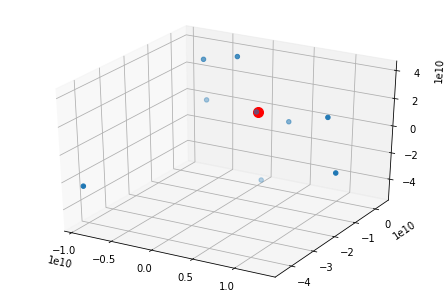

In [3]:
plot_network(nodes)

In [4]:
### TEST disable links
### sorted nodes = [0 4 5 8 1 2 9 3 6 7]

if(False):   #TEST
    At = disable_links(A,100,mode="light")

    for i in range(20):
        B = np.copy(At[:,:,i*5])
        B[B>tau_max] = 0
        plt.spy(B)
        plt.show()

# Greedy Routing

In every network where data is generated from a node and needs to be delivered to a different one, may it be the postal network or the internet, it is necessary to find out the route that the data should follow in order to reach its destination.

This is usually done by a routing algorithm, in the internet the most widely used ones are the Dijikstra and the Bellman-Ford algorithm, these two are used in order to find the shortest way from the source to the destination according to some metric that could be the number of hops, the end to end delay etc.
<!-- The code below is html and I used it because it gives much more freedom for
controlling images-->
<figure>
    <img src="figures/routing.svg" width=500/>
    <div style="text-align: center;"> 
        <i>
            Path obtained by applying routing between the two nodes
        </i>
    </div>
</figure>
Classical routing algorithms do not work on DTNs (Delay Tolerant Networks) because they were thought for systems where links are supposed to fail very rarely and where the end to end delay is relatively small.

In the internet the chance of a link failing is low and even if it does the end to end delay is small, so in case a packet is lost because of link failure sending the packet again is not too expensive.
In DTNs this is not true because:

* The propagation time is very high, expecially if we are conisdering satellite communication

* The chanche of link failure is very high.

On top of that it is not even possible to find the best routing algorithm for networks in general because if the traffic generated by other nodes is considered the problem becomes NP.
By analyzing the state of the art in DTN it is possible to see that the best results were mostly obtained by using greedy algorithms, i. e. algorithms that make a decision by choosing the best choice at the moment without considering long term planning.

In order to perform routing, during the first part of the project, full knowledge of the network topology and also its evolution is taken as a given, this is not a very strict requirement as this might happen in real life. For example for satellite networks, where usually link failure is caused by the interference of a celestial body, the requirement can be easily satisfied.

The algorithm implemented with this work chooses the best next hop for the packet by using a slightly modified version of the dijkstra algorithm that computes the best path from the source to the destination at a specific point in time.

It is also necessary to take collisions into account, so if sending one packet causes one the sender needs to wait until it is sure that no collision will occur, after waiting the optimal path needs to be recomputed because due to topology changes it might not be optimal anymore.

## Modified Dijkstra

The Dijkstra algorithm cam be used to find the best path between two nodes in a weighted graph with positive weights.

<figure>
    <img src="figures/dijkstra.gif" width=300/>
    <div style="text-align: center;"> 
        <i>
            Dijkstra algorithm in action
        </i>
    </div>
</figure>

Usually the algorithm is run on graphs that have constant topology but in this case the topology changes a lot so a link that was active when the packet was sent might not be active when the packet reaches its destination.

A nice implementation of the Dijkstra algorithm for DTNs was proposed in [1], in there the weigth of a node is considered equal to the time it would take the packet to reach the next hop considering that the link might fail.

The pseudo code for the algorithm is:
```
Input = G=(E, V), s, T, w(e,t)
Q = V
L[s]=0
L[v]=inf for every v != s
while Q != {} do
    u = u in Q that minimizes L[u]
    Q = Q - u
    for each edge e in E between u and another vertex v do
        if L[v] > L[u] + w(e, T + L[u]) then
            L[v] = L[u] + w(e, T + L[u])
        end if
    end for
end while
```
Where G is the graph representing the network, s is the starting node, T is the starting time, w(e,t) is the weight of edge e at time t.
The only difference from the standard algorithm is that in the standard case w(e,t) is constant in t.


In [5]:
At = disable_links(A,5000,mode="unstable")

In [6]:
packets = np.random.randint(1, n, (100, 2))
packets[:,1] = 0
packets = packets[packets[:, 0] != 0]
print(len(packets))
#print(packets)
delta_time = 50
ttr = 50
packets = greedy_routing(At, packets, ttr, delta_time)

100
id: 3, next hop: 0, destination: 0, arrival time = 50.943771238194515
id: 1, next hop: 0, destination: 0, arrival time = 74.31382415662284
id: 2, next hop: 0, destination: 0, arrival time = 77.34131793699059
id: 8, next hop: 0, destination: 0, arrival time = 100.94377123819451
id: 1, next hop: 0, destination: 0, arrival time = 100.94377133819451
id: 2, next hop: 0, destination: 0, arrival time = 100.94377133819451
id: 6, next hop: 0, destination: 0, arrival time = 105.67387701875924
id: 5, next hop: 0, destination: 0, arrival time = 134.90351814982662
id: 13, next hop: 0, destination: 0, arrival time = 150.94377123819453
id: 1, next hop: 0, destination: 0, arrival time = 150.9437713381945
id: 2, next hop: 0, destination: 0, arrival time = 150.9437713381945
id: 6, next hop: 0, destination: 0, arrival time = 150.94377133819452
id: 5, next hop: 0, destination: 0, arrival time = 150.94377133819452
id: 30, next hop: 0, destination: 0, arrival time = 165.01866588545
id: 0, next hop: 0, d

id: 4, next hop: 0, destination: 0, arrival time = 850.9437714381945
id: 1, next hop: 0, destination: 0, arrival time = 850.9437714381945
id: 5, next hop: 0, destination: 0, arrival time = 850.9437714381946
id: 0, next hop: 0, destination: 0, arrival time = 850.9437714381946
id: 7, next hop: 0, destination: 0, arrival time = 850.9437714381946
id: 2, next hop: 0, destination: 0, arrival time = 850.9437714381946
id: 30, next hop: 0, destination: 0, arrival time = 850.9437714381946
id: 51, next hop: 0, destination: 0, arrival time = 900.9437713381947
id: 4, next hop: 0, destination: 0, arrival time = 900.9437714381945
id: 1, next hop: 0, destination: 0, arrival time = 900.9437714381945
id: 5, next hop: 0, destination: 0, arrival time = 900.9437714381946
id: 0, next hop: 0, destination: 0, arrival time = 900.9437714381946
id: 7, next hop: 0, destination: 0, arrival time = 900.9437714381946
id: 2, next hop: 0, destination: 0, arrival time = 900.9437714381946
id: 30, next hop: 0, destination

id: 7, next hop: 0, destination: 0, arrival time = 1700.9437715381948
id: 2, next hop: 0, destination: 0, arrival time = 1700.9437715381948
id: 30, next hop: 0, destination: 0, arrival time = 1700.9437715381948
id: 83, next hop: 0, destination: 0, arrival time = 1750.9437714381947
id: 4, next hop: 0, destination: 0, arrival time = 1750.9437715381948
id: 1, next hop: 0, destination: 0, arrival time = 1750.9437715381948
id: 0, next hop: 0, destination: 0, arrival time = 1750.9437715381948
id: 7, next hop: 0, destination: 0, arrival time = 1750.9437715381948
id: 2, next hop: 0, destination: 0, arrival time = 1750.9437715381948
id: 30, next hop: 0, destination: 0, arrival time = 1750.9437715381948
id: 96, next hop: 0, destination: 0, arrival time = 1800.9437714381947
id: 4, next hop: 0, destination: 0, arrival time = 1800.9437715381948
id: 1, next hop: 0, destination: 0, arrival time = 1800.9437715381948
id: 0, next hop: 0, destination: 0, arrival time = 1800.9437715381948
id: 7, next hop:

id: 55, next hop: 0, destination: 0, arrival time = 3400.9437718381946
id: 7, next hop: 0, destination: 0, arrival time = 3400.9437719381945
id: 2, next hop: 0, destination: 0, arrival time = 3400.9437719381945
id: 30, next hop: 0, destination: 0, arrival time = 3400.9437719381945
id: 72, next hop: 0, destination: 0, arrival time = 3450.9437718381946
id: 7, next hop: 0, destination: 0, arrival time = 3450.9437719381945
id: 2, next hop: 0, destination: 0, arrival time = 3450.9437719381945
id: 30, next hop: 0, destination: 0, arrival time = 3450.9437719381945
id: 79, next hop: 0, destination: 0, arrival time = 3500.9437718381946
id: 7, next hop: 0, destination: 0, arrival time = 3500.9437719381945
id: 2, next hop: 0, destination: 0, arrival time = 3500.9437719381945
id: 30, next hop: 0, destination: 0, arrival time = 3500.9437719381945
id: 7, next hop: 0, destination: 0, arrival time = 3550.9437719381945
id: 2, next hop: 0, destination: 0, arrival time = 3550.9437719381945
id: 30, next h

In [7]:
packets = np.random.randint(1, n, (100, 2))
packets[:,1] = 0
if False:
    ttrs = range(1, 300, 50)
    max_rand = 10
    outputs = np.zeros((len(ttrs), max_rand))

    for rand_iter in tqdm(range(max_rand)):

        nodes = generate_network(n,r_max)
        A = adjacency_matrix(nodes,tau_max)
        At = disable_links(A,5000,mode="unstable")

        for ttr_ind in range(len(ttrs)):


            results = greedy_routing(At, packets, ttrs[ttr_ind], delta_time)
            arrival_times = np.array([packet.arrival_times[-1] for packet in results])
            outputs[ttr_ind, rand_iter] = np.max(arrival_times)

    arrival_times = np.mean(outputs, axis = 1)
    plt.plot(ttrs, arrival_times)

In [8]:
ttr = 1
max_rand = 10

if False:
    r_maxes = [r_max/32*2**i for i in range(10)]
    outputs = np.zeros((len(r_maxes), max_rand))

    for i, rand_iter in tqdm(product(range(len(r_maxes)), range(max_rand))):
        tau_max_i = r_maxes[i]/c

        nodes = generate_network(n, r_maxes[i])
        A = adjacency_matrix(nodes, tau_max_i)

        At = disable_links(A,5000,mode="unstable")

        results = greedy_routing(At, packets, ttr, delta_time)
        arrival_times = np.array([packet.arrival_times[-1] for packet in results])
        outputs[i, rand_iter] = np.max(arrival_times)

    arrival_times = np.mean(outputs, axis = 1)
    plt.plot(r_maxes, arrival_times)

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0.         191.21554218 109.14161625 137.1704507   82.1415366
  176.52786134 146.43747046  83.49836384 114.46361805  94.42246556]
 [191.21554218   0.          91.54711893  56.52076232          inf
           inf          inf          inf          inf          inf]
 [109.14161625  91.54711893   0.          51.72180488 164.88987301
           inf          inf 185.53704798 129.36046893 187.63867825]
 [137.1704507   56.52076232  51.72180488   0.         183.03024339
           inf          inf          inf 171.56034857          inf]
 [ 82.1415366           inf 164.88987301 183.03024339   0.
           inf  65.82235824 112.38096829 191.67244205  98.97929112]
 [176.52786134          inf          inf          inf          inf
    0.                  inf 162.39677209 100.18961384 196.20149274]
 [146.43747046          inf          inf          inf  65.82235824
           inf   0.         171.86666799          inf 142.40188953]
 [ 83.49836384          inf 185.53704798          inf 112.380968

id: 37, next hop: 0, destination: 0, arrival time = 11.248560327593603
id: 43, next hop: 0, destination: 0, arrival time = 12.248560327593603
id: 55, next hop: 0, destination: 0, arrival time = 13.248560327593603
id: 59, next hop: 0, destination: 0, arrival time = 14.248560327593603
id: 16, next hop: 0, destination: 0, arrival time = 14.877908067359181
id: 63, next hop: 0, destination: 0, arrival time = 15.248560327593603
id: 16, next hop: 0, destination: 0, arrival time = 15.248560427593603
id: 16, next hop: 0, destination: 0, arrival time = 16.248560427593603
id: 20, next hop: 0, destination: 0, arrival time = 17.248560427593603
id: 24, next hop: 0, destination: 0, arrival time = 18.248560427593603
id: 25, next hop: 0, destination: 0, arrival time = 19.248560427593603
id: 29, next hop: 0, destination: 0, arrival time = 20.248560427593603
id: 35, next hop: 0, destination: 0, arrival time = 21.248560427593603
id: 38, next hop: 0, destination: 0, arrival time = 22.248560427593603
id: 1,

id: 28, next hop: 0, destination: 0, arrival time = 30.248560527593604
id: 108, next hop: 0, destination: 0, arrival time = 31.248560427593603
id: 28, next hop: 0, destination: 0, arrival time = 31.248560527593604
id: 109, next hop: 0, destination: 0, arrival time = 32.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 32.248560527593604
id: 113, next hop: 0, destination: 0, arrival time = 33.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 33.248560527593604
id: 116, next hop: 0, destination: 0, arrival time = 34.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 34.248560527593604
id: 117, next hop: 0, destination: 0, arrival time = 35.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 35.248560527593604
id: 119, next hop: 0, destination: 0, arrival time = 36.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 36.248560527593604
id: 28, next hop: 0, destination: 0, arrival time = 37.248560527593604
id: 32, ne

id: 99, next hop: 0, destination: 0, arrival time = 204.39666653039026
id: 18, next hop: 0, destination: 0, arrival time = 204.39666663039026
id: 27, next hop: 0, destination: 0, arrival time = 204.39666663039026
id: 102, next hop: 0, destination: 0, arrival time = 205.39666653039026
id: 18, next hop: 0, destination: 0, arrival time = 205.39666663039026
id: 27, next hop: 0, destination: 0, arrival time = 205.39666663039026
id: 112, next hop: 0, destination: 0, arrival time = 206.39666653039026
id: 18, next hop: 0, destination: 0, arrival time = 206.39666663039026
id: 27, next hop: 0, destination: 0, arrival time = 206.39666663039026
id: 118, next hop: 0, destination: 0, arrival time = 207.39666653039026
id: 18, next hop: 0, destination: 0, arrival time = 207.39666663039026
id: 27, next hop: 0, destination: 0, arrival time = 207.39666663039026
id: 126, next hop: 0, destination: 0, arrival time = 208.39666653039026
id: 18, next hop: 0, destination: 0, arrival time = 208.39666663039026
id

id: 82, next hop: 0, destination: 0, arrival time = 40.248560527593604
id: 170, next hop: 0, destination: 0, arrival time = 41.2485604275936
id: 82, next hop: 0, destination: 0, arrival time = 41.248560527593604
id: 179, next hop: 0, destination: 0, arrival time = 42.2485604275936
id: 82, next hop: 0, destination: 0, arrival time = 42.248560527593604
id: 185, next hop: 0, destination: 0, arrival time = 43.2485604275936
id: 82, next hop: 0, destination: 0, arrival time = 43.248560527593604
id: 207, next hop: 0, destination: 0, arrival time = 44.2485604275936
id: 82, next hop: 0, destination: 0, arrival time = 44.248560527593604
id: 217, next hop: 0, destination: 0, arrival time = 45.2485604275936
id: 82, next hop: 0, destination: 0, arrival time = 45.248560527593604
id: 225, next hop: 0, destination: 0, arrival time = 46.2485604275936
id: 82, next hop: 0, destination: 0, arrival time = 46.248560527593604
id: 226, next hop: 0, destination: 0, arrival time = 47.2485604275936
id: 82, next 

id: 3, next hop: 0, destination: 0, arrival time = 107.2485608275936
id: 117, next hop: 0, destination: 0, arrival time = 108.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 108.2485608275936
id: 120, next hop: 0, destination: 0, arrival time = 109.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 109.2485608275936
id: 122, next hop: 0, destination: 0, arrival time = 110.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 110.2485608275936
id: 126, next hop: 0, destination: 0, arrival time = 111.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 111.2485608275936
id: 131, next hop: 0, destination: 0, arrival time = 112.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 112.2485608275936
id: 136, next hop: 0, destination: 0, arrival time = 113.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 113.2485608275936
id: 137, next hop: 0, destination: 0, arrival time = 114.2485607275936
id: 3, next hop: 0, 

id: 15, next hop: 0, destination: 0, arrival time = 197.39666653039026
id: 4, next hop: 0, destination: 0, arrival time = 197.39666653039026
id: 155, next hop: 0, destination: 0, arrival time = 198.39666643039027
id: 1, next hop: 0, destination: 0, arrival time = 198.39666653039026
id: 15, next hop: 0, destination: 0, arrival time = 198.39666653039026
id: 4, next hop: 0, destination: 0, arrival time = 198.39666653039026
id: 165, next hop: 0, destination: 0, arrival time = 199.39666643039027
id: 1, next hop: 0, destination: 0, arrival time = 199.39666653039026
id: 15, next hop: 0, destination: 0, arrival time = 199.39666653039026
id: 4, next hop: 0, destination: 0, arrival time = 199.39666653039026
id: 166, next hop: 0, destination: 0, arrival time = 200.39666643039027
id: 1, next hop: 0, destination: 0, arrival time = 200.39666653039026
id: 15, next hop: 0, destination: 0, arrival time = 200.39666653039026
id: 4, next hop: 0, destination: 0, arrival time = 200.39666653039026
id: 168, n

id: 4, next hop: 0, destination: 0, arrival time = 231.39666663039026
id: 213, next hop: 0, destination: 0, arrival time = 232.39666653039026
id: 15, next hop: 0, destination: 0, arrival time = 232.39666663039026
id: 4, next hop: 0, destination: 0, arrival time = 232.39666663039026
id: 214, next hop: 0, destination: 0, arrival time = 233.39666653039026
id: 15, next hop: 0, destination: 0, arrival time = 233.39666663039026
id: 4, next hop: 0, destination: 0, arrival time = 233.39666663039026
id: 220, next hop: 0, destination: 0, arrival time = 234.39666653039026
id: 15, next hop: 0, destination: 0, arrival time = 234.39666663039026
id: 4, next hop: 0, destination: 0, arrival time = 234.39666663039026
id: 229, next hop: 0, destination: 0, arrival time = 235.39666653039026
id: 15, next hop: 0, destination: 0, arrival time = 235.39666663039026
id: 4, next hop: 0, destination: 0, arrival time = 235.39666663039026
id: 235, next hop: 0, destination: 0, arrival time = 236.39666653039026
id: 15

id: 78, next hop: 0, destination: 0, arrival time = 24.248560427593603
id: 45, next hop: 0, destination: 0, arrival time = 24.248560527593604
id: 85, next hop: 0, destination: 0, arrival time = 25.248560427593603
id: 45, next hop: 0, destination: 0, arrival time = 25.248560527593604
id: 92, next hop: 0, destination: 0, arrival time = 26.248560427593603
id: 45, next hop: 0, destination: 0, arrival time = 26.248560527593604
id: 93, next hop: 0, destination: 0, arrival time = 27.248560427593603
id: 45, next hop: 0, destination: 0, arrival time = 27.248560527593604
id: 103, next hop: 0, destination: 0, arrival time = 28.248560427593603
id: 45, next hop: 0, destination: 0, arrival time = 28.248560527593604
id: 104, next hop: 0, destination: 0, arrival time = 29.248560427593603
id: 45, next hop: 0, destination: 0, arrival time = 29.248560527593604
id: 107, next hop: 0, destination: 0, arrival time = 30.248560427593603
id: 45, next hop: 0, destination: 0, arrival time = 30.248560527593604
id:

id: 25, next hop: 0, destination: 0, arrival time = 76.2485605275936
id: 9, next hop: 0, destination: 0, arrival time = 76.2485605275936
id: 45, next hop: 0, destination: 0, arrival time = 76.2485605275936
id: 25, next hop: 0, destination: 0, arrival time = 77.2485605275936
id: 9, next hop: 0, destination: 0, arrival time = 77.2485605275936
id: 45, next hop: 0, destination: 0, arrival time = 77.2485605275936
id: 32, next hop: 0, destination: 0, arrival time = 78.2485605275936
id: 9, next hop: 0, destination: 0, arrival time = 78.24856062759359
id: 45, next hop: 0, destination: 0, arrival time = 78.24856062759359
id: 42, next hop: 0, destination: 0, arrival time = 79.2485605275936
id: 9, next hop: 0, destination: 0, arrival time = 79.24856062759359
id: 45, next hop: 0, destination: 0, arrival time = 79.24856062759359
id: 48, next hop: 0, destination: 0, arrival time = 80.2485605275936
id: 9, next hop: 0, destination: 0, arrival time = 80.24856062759359
id: 45, next hop: 0, destination: 

id: 9, next hop: 0, destination: 0, arrival time = 111.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 111.2485606275936
id: 295, next hop: 0, destination: 0, arrival time = 112.2485605275936
id: 45, next hop: 0, destination: 0, arrival time = 112.24856062759359
id: 9, next hop: 0, destination: 0, arrival time = 112.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 112.2485606275936
id: 305, next hop: 0, destination: 0, arrival time = 113.2485605275936
id: 45, next hop: 0, destination: 0, arrival time = 113.24856062759359
id: 9, next hop: 0, destination: 0, arrival time = 113.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 113.2485606275936
id: 307, next hop: 0, destination: 0, arrival time = 114.2485605275936
id: 45, next hop: 0, destination: 0, arrival time = 114.24856062759359
id: 9, next hop: 0, destination: 0, arrival time = 114.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 114.2485606275936
id: 319, next hop:

id: 45, next hop: 0, destination: 0, arrival time = 143.2485607275936
id: 87, next hop: 0, destination: 0, arrival time = 144.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 144.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 144.2485607275936
id: 105, next hop: 0, destination: 0, arrival time = 145.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 145.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 145.2485607275936
id: 127, next hop: 0, destination: 0, arrival time = 146.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 146.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 146.2485607275936
id: 144, next hop: 0, destination: 0, arrival time = 147.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 147.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 147.2485607275936
id: 151, next hop: 0, destination: 0, arrival time = 148.2485606275936
id: 11, next hop

id: 11, next hop: 0, destination: 0, arrival time = 182.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 182.2485607275936
id: 0, next hop: 0, destination: 0, arrival time = 182.2485607275936
id: 449, next hop: 0, destination: 0, arrival time = 183.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 183.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 183.2485607275936
id: 0, next hop: 0, destination: 0, arrival time = 183.2485607275936
id: 452, next hop: 0, destination: 0, arrival time = 184.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 184.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 184.2485607275936
id: 0, next hop: 0, destination: 0, arrival time = 184.2485607275936
id: 473, next hop: 0, destination: 0, arrival time = 185.2485606275936
id: 11, next hop: 0, destination: 0, arrival time = 185.2485607275936
id: 45, next hop: 0, destination: 0, arrival time = 185.2485607275936
id: 0, next hop: 0, 

id: 0, next hop: 0, destination: 0, arrival time = 202.2485608275936
id: 67, next hop: 0, destination: 0, arrival time = 203.2485607275936
id: 4, next hop: 0, destination: 0, arrival time = 203.2485608275936
id: 11, next hop: 0, destination: 0, arrival time = 203.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 203.2485608275936
id: 45, next hop: 0, destination: 0, arrival time = 203.2485608275936
id: 0, next hop: 0, destination: 0, arrival time = 203.2485608275936
id: 75, next hop: 0, destination: 0, arrival time = 204.2485607275936
id: 4, next hop: 0, destination: 0, arrival time = 204.2485608275936
id: 11, next hop: 0, destination: 0, arrival time = 204.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 204.2485608275936
id: 45, next hop: 0, destination: 0, arrival time = 204.2485608275936
id: 0, next hop: 0, destination: 0, arrival time = 204.2485608275936
id: 77, next hop: 0, destination: 0, arrival time = 205.2485607275936
id: 4, next hop: 0, destina

id: 4, next hop: 0, destination: 0, arrival time = 223.2485608275936
id: 11, next hop: 0, destination: 0, arrival time = 223.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 223.2485608275936
id: 45, next hop: 0, destination: 0, arrival time = 223.2485608275936
id: 0, next hop: 0, destination: 0, arrival time = 223.2485608275936
id: 255, next hop: 0, destination: 0, arrival time = 224.2485607275936
id: 4, next hop: 0, destination: 0, arrival time = 224.2485608275936
id: 11, next hop: 0, destination: 0, arrival time = 224.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 224.2485608275936
id: 45, next hop: 0, destination: 0, arrival time = 224.2485608275936
id: 0, next hop: 0, destination: 0, arrival time = 224.2485608275936
id: 260, next hop: 0, destination: 0, arrival time = 225.2485607275936
id: 4, next hop: 0, destination: 0, arrival time = 225.2485608275936
id: 11, next hop: 0, destination: 0, arrival time = 225.2485608275936
id: 2, next hop: 0, desti

id: 0, next hop: 0, destination: 0, arrival time = 242.2485608275936
id: 375, next hop: 0, destination: 0, arrival time = 243.2485607275936
id: 4, next hop: 0, destination: 0, arrival time = 243.2485608275936
id: 11, next hop: 0, destination: 0, arrival time = 243.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 243.2485608275936
id: 45, next hop: 0, destination: 0, arrival time = 243.2485608275936
id: 0, next hop: 0, destination: 0, arrival time = 243.2485608275936
id: 391, next hop: 0, destination: 0, arrival time = 244.2485607275936
id: 4, next hop: 0, destination: 0, arrival time = 244.2485608275936
id: 11, next hop: 0, destination: 0, arrival time = 244.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 244.2485608275936
id: 45, next hop: 0, destination: 0, arrival time = 244.2485608275936
id: 0, next hop: 0, destination: 0, arrival time = 244.2485608275936
id: 393, next hop: 0, destination: 0, arrival time = 245.2485607275936
id: 4, next hop: 0, dest

id: 2, next hop: 0, destination: 0, arrival time = 263.24856092759353
id: 0, next hop: 0, destination: 0, arrival time = 263.24856092759353
id: 45, next hop: 0, destination: 0, arrival time = 263.2485609275936
id: 71, next hop: 0, destination: 0, arrival time = 264.24856082759356
id: 11, next hop: 0, destination: 0, arrival time = 264.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 264.24856092759353
id: 0, next hop: 0, destination: 0, arrival time = 264.24856092759353
id: 45, next hop: 0, destination: 0, arrival time = 264.2485609275936
id: 72, next hop: 0, destination: 0, arrival time = 265.24856082759356
id: 11, next hop: 0, destination: 0, arrival time = 265.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 265.24856092759353
id: 0, next hop: 0, destination: 0, arrival time = 265.24856092759353
id: 45, next hop: 0, destination: 0, arrival time = 265.2485609275936
id: 89, next hop: 0, destination: 0, arrival time = 266.24856082759356
id: 11, next ho

id: 317, next hop: 0, destination: 0, arrival time = 288.24856082759356
id: 11, next hop: 0, destination: 0, arrival time = 288.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 288.24856092759353
id: 0, next hop: 0, destination: 0, arrival time = 288.24856092759353
id: 45, next hop: 0, destination: 0, arrival time = 288.2485609275936
id: 322, next hop: 0, destination: 0, arrival time = 289.24856082759356
id: 11, next hop: 0, destination: 0, arrival time = 289.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 289.24856092759353
id: 0, next hop: 0, destination: 0, arrival time = 289.24856092759353
id: 45, next hop: 0, destination: 0, arrival time = 289.2485609275936
id: 331, next hop: 0, destination: 0, arrival time = 290.24856082759356
id: 11, next hop: 0, destination: 0, arrival time = 290.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 290.24856092759353
id: 0, next hop: 0, destination: 0, arrival time = 290.24856092759353
id: 45, nex

id: 101, next hop: 0, destination: 0, arrival time = 315.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 315.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 315.2485610275935
id: 45, next hop: 0, destination: 0, arrival time = 315.24856102759355
id: 108, next hop: 0, destination: 0, arrival time = 316.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 316.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 316.2485610275935
id: 45, next hop: 0, destination: 0, arrival time = 316.24856102759355
id: 112, next hop: 0, destination: 0, arrival time = 317.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 317.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 317.2485610275935
id: 45, next hop: 0, destination: 0, arrival time = 317.24856102759355
id: 114, next hop: 0, destination: 0, arrival time = 318.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 318.2485610275935
id: 0, next hop:

id: 2, next hop: 0, destination: 0, arrival time = 344.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 344.2485610275935
id: 45, next hop: 0, destination: 0, arrival time = 344.24856102759355
id: 387, next hop: 0, destination: 0, arrival time = 345.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 345.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 345.2485610275935
id: 45, next hop: 0, destination: 0, arrival time = 345.24856102759355
id: 406, next hop: 0, destination: 0, arrival time = 346.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 346.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 346.2485610275935
id: 45, next hop: 0, destination: 0, arrival time = 346.24856102759355
id: 409, next hop: 0, destination: 0, arrival time = 347.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 347.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 347.2485610275935
id: 45, next hop: 0

id: 45, next hop: 0, destination: 0, arrival time = 382.2485611275935
id: 251, next hop: 0, destination: 0, arrival time = 383.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 383.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 383.2485611275935
id: 252, next hop: 0, destination: 0, arrival time = 384.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 384.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 384.2485611275935
id: 270, next hop: 0, destination: 0, arrival time = 385.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 385.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 385.2485611275935
id: 274, next hop: 0, destination: 0, arrival time = 386.2485610275935
id: 0, next hop: 0, destination: 0, arrival time = 386.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 386.2485611275935
id: 293, next hop: 0, destination: 0, arrival time = 387.2485610275935
id: 0, next hop

id: 45, next hop: 0, destination: 0, arrival time = 429.2485612275935
id: 149, next hop: 0, destination: 0, arrival time = 430.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 430.2485612275935
id: 154, next hop: 0, destination: 0, arrival time = 431.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 431.2485612275935
id: 157, next hop: 0, destination: 0, arrival time = 432.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 432.2485612275935
id: 202, next hop: 0, destination: 0, arrival time = 433.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 433.2485612275935
id: 210, next hop: 0, destination: 0, arrival time = 434.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 434.2485612275935
id: 226, next hop: 0, destination: 0, arrival time = 435.24856112759346
id: 45, next hop: 0, destination: 0, arrival time = 435.2485612275935
id: 228, next hop: 0, destination: 0, arrival time = 436.24856112759346
id: 45

id: 59, next hop: 0, destination: 0, arrival time = 14.248560327593603
id: 0, next hop: 0, destination: 0, arrival time = 14.877908067359181
id: 74, next hop: 0, destination: 0, arrival time = 15.248560327593603
id: 0, next hop: 0, destination: 0, arrival time = 15.248560427593603
id: 85, next hop: 0, destination: 0, arrival time = 16.2485603275936
id: 0, next hop: 0, destination: 0, arrival time = 16.248560427593603
id: 85, next hop: 0, destination: 0, arrival time = 16.248560427593603
id: 23, next hop: 0, destination: 0, arrival time = 17.248560427593603
id: 85, next hop: 0, destination: 0, arrival time = 17.248560527593604
id: 32, next hop: 0, destination: 0, arrival time = 18.248560427593603
id: 85, next hop: 0, destination: 0, arrival time = 18.248560527593604
id: 33, next hop: 0, destination: 0, arrival time = 19.248560427593603
id: 85, next hop: 0, destination: 0, arrival time = 19.248560527593604
id: 38, next hop: 0, destination: 0, arrival time = 20.248560427593603
id: 85, nex

id: 5, next hop: 0, destination: 0, arrival time = 69.2485605275936
id: 85, next hop: 0, destination: 0, arrival time = 69.24856052759361
id: 447, next hop: 0, destination: 0, arrival time = 70.2485604275936
id: 5, next hop: 0, destination: 0, arrival time = 70.2485605275936
id: 85, next hop: 0, destination: 0, arrival time = 70.24856052759361
id: 448, next hop: 0, destination: 0, arrival time = 71.2485604275936
id: 5, next hop: 0, destination: 0, arrival time = 71.2485605275936
id: 85, next hop: 0, destination: 0, arrival time = 71.24856052759361
id: 451, next hop: 0, destination: 0, arrival time = 72.2485604275936
id: 5, next hop: 0, destination: 0, arrival time = 72.2485605275936
id: 85, next hop: 0, destination: 0, arrival time = 72.24856052759361
id: 455, next hop: 0, destination: 0, arrival time = 73.2485604275936
id: 5, next hop: 0, destination: 0, arrival time = 73.2485605275936
id: 85, next hop: 0, destination: 0, arrival time = 73.24856052759361
id: 473, next hop: 0, destinat

id: 85, next hop: 0, destination: 0, arrival time = 99.2485605275936
id: 5, next hop: 0, destination: 0, arrival time = 99.24856052759361
id: 16, next hop: 0, destination: 0, arrival time = 99.24856052759361
id: 669, next hop: 0, destination: 0, arrival time = 100.2485604275936
id: 12, next hop: 0, destination: 0, arrival time = 100.2485605275936
id: 85, next hop: 0, destination: 0, arrival time = 100.2485605275936
id: 5, next hop: 0, destination: 0, arrival time = 100.24856052759361
id: 16, next hop: 0, destination: 0, arrival time = 100.24856052759361
id: 672, next hop: 0, destination: 0, arrival time = 101.2485604275936
id: 12, next hop: 0, destination: 0, arrival time = 101.2485605275936
id: 85, next hop: 0, destination: 0, arrival time = 101.2485605275936
id: 5, next hop: 0, destination: 0, arrival time = 101.24856052759361
id: 16, next hop: 0, destination: 0, arrival time = 101.24856052759361
id: 689, next hop: 0, destination: 0, arrival time = 102.2485604275936
id: 12, next hop:

id: 12, next hop: 0, destination: 0, arrival time = 122.24856052759361
id: 897, next hop: 0, destination: 0, arrival time = 123.2485604275936
id: 85, next hop: 0, destination: 0, arrival time = 123.2485605275936
id: 5, next hop: 0, destination: 0, arrival time = 123.24856052759361
id: 16, next hop: 0, destination: 0, arrival time = 123.24856052759361
id: 12, next hop: 0, destination: 0, arrival time = 123.24856052759361
id: 902, next hop: 0, destination: 0, arrival time = 124.2485604275936
id: 85, next hop: 0, destination: 0, arrival time = 124.2485605275936
id: 5, next hop: 0, destination: 0, arrival time = 124.24856052759361
id: 16, next hop: 0, destination: 0, arrival time = 124.24856052759361
id: 12, next hop: 0, destination: 0, arrival time = 124.24856052759361
id: 910, next hop: 0, destination: 0, arrival time = 125.2485604275936
id: 85, next hop: 0, destination: 0, arrival time = 125.2485605275936
id: 5, next hop: 0, destination: 0, arrival time = 125.24856052759361
id: 16, next

id: 16, next hop: 0, destination: 0, arrival time = 148.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 148.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 148.24856072759357
id: 54, next hop: 0, destination: 0, arrival time = 149.24856062759358
id: 16, next hop: 0, destination: 0, arrival time = 149.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 149.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 149.24856072759357
id: 58, next hop: 0, destination: 0, arrival time = 150.24856062759358
id: 16, next hop: 0, destination: 0, arrival time = 150.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 150.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 150.24856072759357
id: 86, next hop: 0, destination: 0, arrival time = 151.24856062759358
id: 16, next hop: 0, destination: 0, arrival time = 151.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 151.24856072759357
id: 85

id: 12, next hop: 0, destination: 0, arrival time = 177.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 177.24856072759357
id: 385, next hop: 0, destination: 0, arrival time = 178.24856062759358
id: 16, next hop: 0, destination: 0, arrival time = 178.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 178.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 178.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 178.39666643039027
id: 406, next hop: 0, destination: 0, arrival time = 179.24856062759358
id: 16, next hop: 0, destination: 0, arrival time = 179.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 179.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 179.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 179.24856072759357
id: 415, next hop: 0, destination: 0, arrival time = 180.24856062759358
id: 16, next hop: 0, destination: 0, arrival time = 180.24856072759357
id: 1

id: 16, next hop: 0, destination: 0, arrival time = 196.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 196.24856072759357
id: 1, next hop: 0, destination: 0, arrival time = 196.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 196.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 196.24856072759357
id: 549, next hop: 0, destination: 0, arrival time = 197.24856062759358
id: 11, next hop: 0, destination: 0, arrival time = 197.24856072759357
id: 3, next hop: 0, destination: 0, arrival time = 197.24856072759357
id: 16, next hop: 0, destination: 0, arrival time = 197.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 197.24856072759357
id: 1, next hop: 0, destination: 0, arrival time = 197.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 197.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 197.24856072759357
id: 560, next hop: 0, destination: 0, arrival time = 198.24856062759358
id: 11, n

id: 718, next hop: 0, destination: 0, arrival time = 211.24856062759358
id: 11, next hop: 0, destination: 0, arrival time = 211.24856072759357
id: 3, next hop: 0, destination: 0, arrival time = 211.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 211.24856072759357
id: 1, next hop: 0, destination: 0, arrival time = 211.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 211.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 211.24856072759357
id: 16, next hop: 0, destination: 0, arrival time = 211.2485607275936
id: 720, next hop: 0, destination: 0, arrival time = 212.24856062759358
id: 11, next hop: 0, destination: 0, arrival time = 212.24856072759357
id: 3, next hop: 0, destination: 0, arrival time = 212.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 212.24856072759357
id: 1, next hop: 0, destination: 0, arrival time = 212.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 212.24856072759357
id: 2, nex

id: 2, next hop: 0, destination: 0, arrival time = 225.24856072759357
id: 16, next hop: 0, destination: 0, arrival time = 225.2485607275936
id: 826, next hop: 0, destination: 0, arrival time = 226.24856062759358
id: 11, next hop: 0, destination: 0, arrival time = 226.24856072759357
id: 3, next hop: 0, destination: 0, arrival time = 226.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 226.24856072759357
id: 1, next hop: 0, destination: 0, arrival time = 226.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 226.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 226.24856072759357
id: 16, next hop: 0, destination: 0, arrival time = 226.2485607275936
id: 842, next hop: 0, destination: 0, arrival time = 227.24856062759358
id: 11, next hop: 0, destination: 0, arrival time = 227.24856072759357
id: 3, next hop: 0, destination: 0, arrival time = 227.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 227.24856072759357
id: 1, next

id: 1, next hop: 0, destination: 0, arrival time = 240.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 240.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 240.24856072759357
id: 16, next hop: 0, destination: 0, arrival time = 240.2485607275936
id: 1010, next hop: 0, destination: 0, arrival time = 241.24856062759358
id: 11, next hop: 0, destination: 0, arrival time = 241.24856072759357
id: 3, next hop: 0, destination: 0, arrival time = 241.24856072759357
id: 12, next hop: 0, destination: 0, arrival time = 241.24856072759357
id: 1, next hop: 0, destination: 0, arrival time = 241.24856072759357
id: 85, next hop: 0, destination: 0, arrival time = 241.24856072759357
id: 2, next hop: 0, destination: 0, arrival time = 241.24856072759357
id: 16, next hop: 0, destination: 0, arrival time = 241.2485607275936
id: 1014, next hop: 0, destination: 0, arrival time = 242.24856062759358
id: 11, next hop: 0, destination: 0, arrival time = 242.24856072759357
id: 3, ne

id: 85, next hop: 0, destination: 0, arrival time = 256.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 256.24856082759356
id: 111, next hop: 0, destination: 0, arrival time = 257.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 257.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 257.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 257.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 257.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 257.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 257.2485608275936
id: 118, next hop: 0, destination: 0, arrival time = 258.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 258.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 258.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 258.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 258.24856082759356
id: 16, next ho

id: 16, next hop: 0, destination: 0, arrival time = 273.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 273.2485608275936
id: 266, next hop: 0, destination: 0, arrival time = 274.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 274.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 274.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 274.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 274.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 274.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 274.2485608275936
id: 283, next hop: 0, destination: 0, arrival time = 275.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 275.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 275.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 275.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 275.24856082759356
id: 16, next hop

id: 414, next hop: 0, destination: 0, arrival time = 291.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 291.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 291.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 291.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 291.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 291.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 291.2485608275936
id: 429, next hop: 0, destination: 0, arrival time = 292.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 292.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 292.2485608275936
id: 430, next ho

id: 85, next hop: 0, destination: 0, arrival time = 307.2485608275936
id: 568, next hop: 0, destination: 0, arrival time = 308.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 308.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 308.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 308.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 308.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 308.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 308.2485608275936
id: 573, next hop: 0, destination: 0, arrival time = 309.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 309.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 309.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 309.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 309.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 309.2485608275936
id: 85, next hop

id: 3, next hop: 0, destination: 0, arrival time = 325.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 325.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 325.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 325.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 325.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 325.2485608275936
id: 694, next hop: 0, destination: 0, arrival time = 326.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 326.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 326.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 326.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 326.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 326.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 326.2485608275936
id: 705, next hop: 0, destination: 0, arrival time = 327.2485607275936
id: 3, next hop:

id: 3, next hop: 0, destination: 0, arrival time = 342.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 342.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 342.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 342.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 342.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 342.2485608275936
id: 839, next hop: 0, destination: 0, arrival time = 343.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 343.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 343.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 343.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 343.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 343.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 343.2485608275936
id: 844, next hop: 0, destination: 0, arrival time = 344.2485607275936
id: 3, next hop:

id: 3, next hop: 0, destination: 0, arrival time = 359.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 359.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 359.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 359.2485608275936
id: 12, next hop: 0, destination: 0, arrival time = 359.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 359.2485608275936
id: 996, next hop: 0, destination: 0, arrival time = 360.2485607275936
id: 3, next hop: 0, destination: 0, arrival time = 360.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 360.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 360.24856082759356
id: 16, next hop: 0, destination: 0, arrival time = 360.2485608275936
id: 12, next hop: 0, destination: 0, arrival time = 360.2485608275936
id: 85, next hop: 0, destination: 0, arrival time = 360.2485608275936
id: 999, next hop: 0, destination: 0, arrival time = 361.2485607275936
id: 3, next hop: 0

id: 12, next hop: 0, destination: 0, arrival time = 378.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 378.2485609275936
id: 101, next hop: 0, destination: 0, arrival time = 379.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 379.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 379.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 379.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 379.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 379.2485609275936
id: 105, next hop: 0, destination: 0, arrival time = 380.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 380.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 380.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 380.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 380.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 380.2485609275936
id: 113, next ho

id: 1, next hop: 0, destination: 0, arrival time = 398.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 398.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 398.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 398.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 398.2485609275936
id: 295, next hop: 0, destination: 0, arrival time = 399.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 399.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 399.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 399.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 399.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 399.2485609275936
id: 299, next hop: 0, destination: 0, arrival time = 400.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 400.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 400.24856092759353
id: 16, next hop

id: 446, next hop: 0, destination: 0, arrival time = 418.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 418.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 418.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 418.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 418.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 418.2485609275936
id: 450, next hop: 0, destination: 0, arrival time = 419.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 419.24856092759353
id: 2, next hop: 0, destination: 0, arrival time = 419.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 419.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 419.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 419.2485609275936
id: 452, next hop: 0, destination: 0, arrival time = 420.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 420.24856092759353
id: 2, next ho

id: 12, next hop: 0, destination: 0, arrival time = 437.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 437.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 437.2485609275936
id: 674, next hop: 0, destination: 0, arrival time = 438.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 438.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 438.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 438.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 438.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 438.2485609275936
id: 676, next hop: 0, destination: 0, arrival time = 439.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 439.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 439.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 439.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 439.2485609275936
id: 2, next hop: 0

id: 2, next hop: 0, destination: 0, arrival time = 457.2485609275936
id: 824, next hop: 0, destination: 0, arrival time = 458.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 458.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 458.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 458.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 458.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 458.2485609275936
id: 850, next hop: 0, destination: 0, arrival time = 459.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 459.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 459.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 459.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 459.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 459.2485609275936
id: 852, next hop: 0, destination: 0, arrival time = 460.24856082759356
id: 1, next hop: 

id: 16, next hop: 0, destination: 0, arrival time = 478.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 478.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 478.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 478.2485609275936
id: 1022, next hop: 0, destination: 0, arrival time = 479.24856082759356
id: 1, next hop: 0, destination: 0, arrival time = 479.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 479.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 479.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 479.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 479.2485609275936
id: 1, next hop: 0, destination: 0, arrival time = 480.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 480.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 480.2485609275936
id: 85, next hop: 0, destination: 0, arrival time = 480.2485609275936
id: 2, next hop: 0,

id: 85, next hop: 0, destination: 0, arrival time = 502.24856102759355
id: 2, next hop: 0, destination: 0, arrival time = 502.24856102759355
id: 166, next hop: 0, destination: 0, arrival time = 503.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 503.24856102759355
id: 12, next hop: 0, destination: 0, arrival time = 503.24856102759355
id: 85, next hop: 0, destination: 0, arrival time = 503.24856102759355
id: 2, next hop: 0, destination: 0, arrival time = 503.24856102759355
id: 172, next hop: 0, destination: 0, arrival time = 504.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 504.24856102759355
id: 12, next hop: 0, destination: 0, arrival time = 504.24856102759355
id: 85, next hop: 0, destination: 0, arrival time = 504.24856102759355
id: 2, next hop: 0, destination: 0, arrival time = 504.24856102759355
id: 176, next hop: 0, destination: 0, arrival time = 505.24856092759353
id: 16, next hop: 0, destination: 0, arrival time = 505.24856102759355
id: 12

id: 371, next hop: 0, destination: 0, arrival time = 527.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 527.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 527.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 527.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 527.2485610275936
id: 380, next hop: 0, destination: 0, arrival time = 528.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 528.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 528.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 528.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 528.2485610275936
id: 383, next hop: 0, destination: 0, arrival time = 529.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 529.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 529.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 529.2485610275935
id: 16, next hop: 0,

id: 12, next hop: 0, destination: 0, arrival time = 552.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 552.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 552.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 552.2485610275936
id: 630, next hop: 0, destination: 0, arrival time = 553.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 553.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 553.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 553.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 553.2485610275936
id: 631, next hop: 0, destination: 0, arrival time = 554.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 554.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 554.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 554.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 554.2485610275936
id: 639, next hop: 0,

id: 806, next hop: 0, destination: 0, arrival time = 576.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 576.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 576.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 576.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 576.2485610275936
id: 817, next hop: 0, destination: 0, arrival time = 577.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 577.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 577.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 577.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 577.2485610275936
id: 827, next hop: 0, destination: 0, arrival time = 578.2485609275935
id: 12, next hop: 0, destination: 0, arrival time = 578.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 578.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 578.2485610275935
id: 16, next hop: 0,

id: 12, next hop: 0, destination: 0, arrival time = 599.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 599.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 599.2485610275935
id: 1005, next hop: 0, destination: 0, arrival time = 600.2485609275935
id: 16, next hop: 0, destination: 0, arrival time = 600.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 600.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 600.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 600.2485610275935
id: 1013, next hop: 0, destination: 0, arrival time = 601.2485609275935
id: 16, next hop: 0, destination: 0, arrival time = 601.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 601.2485610275935
id: 85, next hop: 0, destination: 0, arrival time = 601.2485610275935
id: 2, next hop: 0, destination: 0, arrival time = 601.2485610275935
id: 16, next hop: 0, destination: 0, arrival time = 602.2485610275935
id: 12, next hop: 0

id: 2, next hop: 0, destination: 0, arrival time = 630.2485611275936
id: 314, next hop: 0, destination: 0, arrival time = 631.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 631.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 631.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 631.2485611275936
id: 340, next hop: 0, destination: 0, arrival time = 632.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 632.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 632.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 632.2485611275936
id: 345, next hop: 0, destination: 0, arrival time = 633.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 633.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 633.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 633.2485611275936
id: 353, next hop: 0, destination: 0, arrival time = 634.2485610275935
id: 12, next hop: 0,

id: 12, next hop: 0, destination: 0, arrival time = 660.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 660.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 660.2485611275936
id: 616, next hop: 0, destination: 0, arrival time = 661.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 661.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 661.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 661.2485611275936
id: 673, next hop: 0, destination: 0, arrival time = 662.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 662.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 662.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 662.2485611275936
id: 685, next hop: 0, destination: 0, arrival time = 663.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 663.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 663.2485611275935
id: 2, next hop: 0, 

id: 2, next hop: 0, destination: 0, arrival time = 690.2485611275936
id: 911, next hop: 0, destination: 0, arrival time = 691.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 691.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 691.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 691.2485611275935
id: 917, next hop: 0, destination: 0, arrival time = 692.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 692.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 692.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 692.2485611275935
id: 924, next hop: 0, destination: 0, arrival time = 693.2485610275935
id: 12, next hop: 0, destination: 0, arrival time = 693.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 693.2485611275935
id: 2, next hop: 0, destination: 0, arrival time = 693.2485611275935
id: 936, next hop: 0, destination: 0, arrival time = 694.2485610275935
id: 12, next hop: 0,

id: 2, next hop: 0, destination: 0, arrival time = 728.2485612275933
id: 214, next hop: 0, destination: 0, arrival time = 729.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 729.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 729.2485612275933
id: 217, next hop: 0, destination: 0, arrival time = 730.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 730.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 730.2485612275933
id: 227, next hop: 0, destination: 0, arrival time = 731.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 731.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 731.2485612275933
id: 232, next hop: 0, destination: 0, arrival time = 732.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 732.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 732.2485612275933
id: 251, next hop: 0, destination: 0, arrival time = 733.2485611275933
id: 85, next hop: 0,

id: 2, next hop: 0, destination: 0, arrival time = 772.2485612275933
id: 624, next hop: 0, destination: 0, arrival time = 773.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 773.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 773.2485612275933
id: 635, next hop: 0, destination: 0, arrival time = 774.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 774.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 774.2485612275933
id: 647, next hop: 0, destination: 0, arrival time = 775.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 775.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 775.2485612275933
id: 650, next hop: 0, destination: 0, arrival time = 776.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 776.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 776.2485612275933
id: 663, next hop: 0, destination: 0, arrival time = 777.2485611275933
id: 85, next hop: 0,

id: 2, next hop: 0, destination: 0, arrival time = 816.2485612275933
id: 1021, next hop: 0, destination: 0, arrival time = 817.2485611275933
id: 85, next hop: 0, destination: 0, arrival time = 817.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 817.2485612275933
id: 85, next hop: 0, destination: 0, arrival time = 818.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 818.2485612275933
id: 94, next hop: 0, destination: 0, arrival time = 819.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 819.2485613275933
id: 128, next hop: 0, destination: 0, arrival time = 820.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 820.2485613275933
id: 129, next hop: 0, destination: 0, arrival time = 821.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 821.2485613275933
id: 139, next hop: 0, destination: 0, arrival time = 822.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 822.2485613275933
id: 151, next hop: 0, 

id: 645, next hop: 0, destination: 0, arrival time = 881.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 881.2485613275933
id: 651, next hop: 0, destination: 0, arrival time = 882.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 882.2485613275933
id: 659, next hop: 0, destination: 0, arrival time = 883.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 883.2485613275933
id: 661, next hop: 0, destination: 0, arrival time = 884.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 884.2485613275933
id: 679, next hop: 0, destination: 0, arrival time = 885.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 885.2485613275933
id: 691, next hop: 0, destination: 0, arrival time = 886.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 886.2485613275933
id: 706, next hop: 0, destination: 0, arrival time = 887.2485612275933
id: 2, next hop: 0, destination: 0, arrival time = 887.2485613275933
id: 707, next hop: 0

id: 421, next hop: 0, destination: 0, arrival time = 962.2485613275933
id: 426, next hop: 0, destination: 0, arrival time = 963.2485613275933
id: 433, next hop: 0, destination: 0, arrival time = 964.2485613275933
id: 441, next hop: 0, destination: 0, arrival time = 965.2485613275933
id: 444, next hop: 0, destination: 0, arrival time = 966.2485613275933
id: 449, next hop: 0, destination: 0, arrival time = 967.2485613275933
id: 459, next hop: 0, destination: 0, arrival time = 968.2485613275933
id: 468, next hop: 0, destination: 0, arrival time = 969.2485613275933
id: 475, next hop: 0, destination: 0, arrival time = 970.2485613275933
id: 477, next hop: 0, destination: 0, arrival time = 971.2485613275933
id: 485, next hop: 0, destination: 0, arrival time = 972.2485613275933
id: 496, next hop: 0, destination: 0, arrival time = 973.2485613275933
id: 498, next hop: 0, destination: 0, arrival time = 974.2485613275933
id: 499, next hop: 0, destination: 0, arrival time = 975.2485613275933
id: 51

id: 80, next hop: 0, destination: 0, arrival time = 33.248560527593604
id: 163, next hop: 0, destination: 0, arrival time = 34.2485604275936
id: 80, next hop: 0, destination: 0, arrival time = 34.248560527593604
id: 177, next hop: 0, destination: 0, arrival time = 35.2485604275936
id: 80, next hop: 0, destination: 0, arrival time = 35.248560527593604
id: 208, next hop: 0, destination: 0, arrival time = 36.2485604275936
id: 80, next hop: 0, destination: 0, arrival time = 36.248560527593604
id: 220, next hop: 0, destination: 0, arrival time = 37.2485604275936
id: 80, next hop: 0, destination: 0, arrival time = 37.248560527593604
id: 228, next hop: 0, destination: 0, arrival time = 38.2485604275936
id: 80, next hop: 0, destination: 0, arrival time = 38.248560527593604
id: 240, next hop: 0, destination: 0, arrival time = 39.2485604275936
id: 80, next hop: 0, destination: 0, arrival time = 39.248560527593604
id: 257, next hop: 0, destination: 0, arrival time = 40.2485604275936
id: 80, next 

id: 80, next hop: 0, destination: 0, arrival time = 80.2485605275936
id: 0, next hop: 0, destination: 0, arrival time = 80.24856052759361
id: 584, next hop: 0, destination: 0, arrival time = 81.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 81.2485605275936
id: 80, next hop: 0, destination: 0, arrival time = 81.2485605275936
id: 0, next hop: 0, destination: 0, arrival time = 81.24856052759361
id: 595, next hop: 0, destination: 0, arrival time = 82.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 82.2485605275936
id: 80, next hop: 0, destination: 0, arrival time = 82.2485605275936
id: 0, next hop: 0, destination: 0, arrival time = 82.24856052759361
id: 603, next hop: 0, destination: 0, arrival time = 83.2485604275936
id: 28, next hop: 0, destination: 0, arrival time = 83.2485605275936
id: 80, next hop: 0, destination: 0, arrival time = 83.2485605275936
id: 0, next hop: 0, destination: 0, arrival time = 83.24856052759361
id: 605, next hop: 0, destinati

id: 28, next hop: 0, destination: 0, arrival time = 106.24856052759361
id: 869, next hop: 0, destination: 0, arrival time = 107.2485604275936
id: 2, next hop: 0, destination: 0, arrival time = 107.2485605275936
id: 80, next hop: 0, destination: 0, arrival time = 107.2485605275936
id: 0, next hop: 0, destination: 0, arrival time = 107.24856052759361
id: 28, next hop: 0, destination: 0, arrival time = 107.24856052759361
id: 872, next hop: 0, destination: 0, arrival time = 108.2485604275936
id: 2, next hop: 0, destination: 0, arrival time = 108.2485605275936
id: 80, next hop: 0, destination: 0, arrival time = 108.2485605275936
id: 0, next hop: 0, destination: 0, arrival time = 108.24856052759361
id: 28, next hop: 0, destination: 0, arrival time = 108.24856052759361
id: 880, next hop: 0, destination: 0, arrival time = 109.2485604275936
id: 2, next hop: 0, destination: 0, arrival time = 109.2485605275936
id: 80, next hop: 0, destination: 0, arrival time = 109.2485605275936
id: 0, next hop: 

id: 80, next hop: 0, destination: 0, arrival time = 130.24856062759358
id: 1106, next hop: 0, destination: 0, arrival time = 131.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 131.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 131.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 131.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 131.24856062759358
id: 1108, next hop: 0, destination: 0, arrival time = 132.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 132.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 132.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 132.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 132.24856062759358
id: 1123, next hop: 0, destination: 0, arrival time = 133.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 133.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 133.24856062759358
id: 2

id: 80, next hop: 0, destination: 0, arrival time = 154.24856062759358
id: 1268, next hop: 0, destination: 0, arrival time = 155.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 155.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 155.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 155.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 155.24856062759358
id: 1270, next hop: 0, destination: 0, arrival time = 156.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 156.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 156.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 156.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 156.24856062759358
id: 1274, next hop: 0, destination: 0, arrival time = 157.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 157.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 157.24856062759358
id: 2

id: 80, next hop: 0, destination: 0, arrival time = 178.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 178.39666643039027
id: 1464, next hop: 0, destination: 0, arrival time = 179.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 179.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 179.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 179.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 179.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 179.24856062759358
id: 1465, next hop: 0, destination: 0, arrival time = 180.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 180.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 180.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 180.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 180.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 180.24856062759358
id: 1467,

id: 0, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 8, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 195.24856062759358
id: 1614, next hop: 0, destination: 0, arrival time = 196.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 196.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 196.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 196.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 196.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 196.24856062759358
id: 8, nex

id: 1674, next hop: 0, destination: 0, arrival time = 208.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 8, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 208.24856062759358
id: 1680, next hop: 0, destination: 0, arrival time = 209.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 209.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 209.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 209.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 209.24856062759358
id: 2, 

id: 12, next hop: 0, destination: 0, arrival time = 221.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 221.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 221.24856062759358
id: 8, next hop: 0, destination: 0, arrival time = 221.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 221.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 221.24856062759358
id: 1779, next hop: 0, destination: 0, arrival time = 222.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 222.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 222.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 222.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 222.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 222.24856062759358
id: 8, next hop: 0, destination: 0, arrival time = 222.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 222.24856062759358
id: 5, nex

id: 8, next hop: 0, destination: 0, arrival time = 234.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 234.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 234.24856062759358
id: 1852, next hop: 0, destination: 0, arrival time = 235.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 8, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 235.24856062759358
id: 1861, next hop: 0, destination: 0, arrival time = 236.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 236.24856062759358
id: 22, n

id: 1936, next hop: 0, destination: 0, arrival time = 248.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 2, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 8, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 80, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 5, next hop: 0, destination: 0, arrival time = 248.24856062759358
id: 1940, next hop: 0, destination: 0, arrival time = 249.24856052759358
id: 0, next hop: 0, destination: 0, arrival time = 249.24856062759358
id: 22, next hop: 0, destination: 0, arrival time = 249.24856062759358
id: 12, next hop: 0, destination: 0, arrival time = 249.24856062759358
id: 28, next hop: 0, destination: 0, arrival time = 249.24856062759358
id: 2, 

id: 22, next hop: 0, destination: 0, arrival time = 261.2485607275936
id: 12, next hop: 0, destination: 0, arrival time = 261.2485607275936
id: 28, next hop: 0, destination: 0, arrival time = 261.2485607275936
id: 2, next hop: 0, destination: 0, arrival time = 261.2485607275936
id: 8, next hop: 0, destination: 0, arrival time = 261.2485607275936
id: 80, next hop: 0, destination: 0, arrival time = 261.2485607275936
id: 5, next hop: 0, destination: 0, arrival time = 261.2485607275936
id: 0, next hop: 0, destination: 0, arrival time = 262.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 262.2485607275936
id: 12, next hop: 0, destination: 0, arrival time = 262.2485607275936
id: 28, next hop: 0, destination: 0, arrival time = 262.2485607275936
id: 2, next hop: 0, destination: 0, arrival time = 262.2485607275936
id: 8, next hop: 0, destination: 0, arrival time = 262.2485607275936
id: 80, next hop: 0, destination: 0, arrival time = 262.2485607275936
id: 5, next hop: 0, destin

id: 12, next hop: 0, destination: 0, arrival time = 276.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 276.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 276.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 276.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 276.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 276.2485608275936
id: 192, next hop: 0, destination: 0, arrival time = 277.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 277.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 277.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 277.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 277.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 277.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 277.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 277.2485608275936
id: 214, next ho

id: 8, next hop: 0, destination: 0, arrival time = 291.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 291.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 291.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 291.2485608275936
id: 336, next hop: 0, destination: 0, arrival time = 292.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 292.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 292.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 292.2485608275936
id: 349, next hop: 0, destination: 0, arrival time = 293.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 293.24856082759356
id: 12, next ho

id: 28, next hop: 0, destination: 0, arrival time = 306.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 306.2485608275936
id: 450, next hop: 0, destination: 0, arrival time = 307.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 307.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 307.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 307.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 307.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 307.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 307.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 307.2485608275936
id: 453, next hop: 0, destination: 0, arrival time = 308.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 308.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 308.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 308.24856082759356
id: 8, next ho

id: 632, next hop: 0, destination: 0, arrival time = 322.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 322.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 322.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 322.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 322.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 322.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 322.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 322.2485608275936
id: 646, next hop: 0, destination: 0, arrival time = 323.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 323.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 323.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 323.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 323.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 323.24856082759356
id: 28, next h

id: 28, next hop: 0, destination: 0, arrival time = 336.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 336.2485608275936
id: 753, next hop: 0, destination: 0, arrival time = 337.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 337.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 337.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 337.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 337.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 337.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 337.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 337.2485608275936
id: 759, next hop: 0, destination: 0, arrival time = 338.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 338.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 338.24856082759356
id: 2, next hop: 0, destination: 0, arrival time = 338.24856082759356
id: 8, next ho

id: 28, next hop: 0, destination: 0, arrival time = 351.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 351.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 351.2485608275936
id: 862, next hop: 0, destination: 0, arrival time = 352.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 352.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 352.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 352.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 352.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 352.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 352.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 352.2485608275936
id: 865, next hop: 0, destination: 0, arrival time = 353.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 353.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 353.24856082759356
id: 8, next hop:

id: 8, next hop: 0, destination: 0, arrival time = 366.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 366.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 366.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 366.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 366.2485608275936
id: 1041, next hop: 0, destination: 0, arrival time = 367.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 367.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 367.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 367.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 367.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 367.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 367.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 367.2485608275936
id: 1044, next hop: 0, destination: 0, arrival time = 368.2485607275936
id: 22, next hop

id: 12, next hop: 0, destination: 0, arrival time = 381.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 381.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 381.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 381.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 381.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 381.2485608275936
id: 1138, next hop: 0, destination: 0, arrival time = 382.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 382.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 382.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 382.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 382.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 382.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 382.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 382.2485608275936
id: 1167, next ho

id: 22, next hop: 0, destination: 0, arrival time = 396.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 396.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 396.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 396.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 396.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 396.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 396.2485608275936
id: 1237, next hop: 0, destination: 0, arrival time = 397.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 397.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 397.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 397.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 397.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 397.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 397.2485608275936
id: 80, next hop

id: 1345, next hop: 0, destination: 0, arrival time = 411.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 411.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 411.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 411.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 411.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 411.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 411.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 411.2485608275936
id: 1369, next hop: 0, destination: 0, arrival time = 412.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 412.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 412.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 412.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 412.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 412.2485608275936
id: 2, next h

id: 80, next hop: 0, destination: 0, arrival time = 425.2485608275936
id: 1503, next hop: 0, destination: 0, arrival time = 426.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 426.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 426.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 426.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 426.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 426.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 426.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 426.2485608275936
id: 1513, next hop: 0, destination: 0, arrival time = 427.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 427.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 427.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 427.24856082759356
id: 5, next hop: 0, destination: 0, arrival time = 427.24856082759356
id: 28, next 

id: 80, next hop: 0, destination: 0, arrival time = 440.2485608275936
id: 5, next hop: 0, destination: 0, arrival time = 440.2485608275936
id: 1610, next hop: 0, destination: 0, arrival time = 441.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 441.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 441.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 441.24856082759356
id: 28, next hop: 0, destination: 0, arrival time = 441.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 441.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 441.2485608275936
id: 5, next hop: 0, destination: 0, arrival time = 441.2485608275936
id: 1639, next hop: 0, destination: 0, arrival time = 442.2485607275936
id: 22, next hop: 0, destination: 0, arrival time = 442.24856082759356
id: 12, next hop: 0, destination: 0, arrival time = 442.24856082759356
id: 8, next hop: 0, destination: 0, arrival time = 442.24856082759356
id: 28, next ho

id: 80, next hop: 0, destination: 0, arrival time = 455.2485608275936
id: 5, next hop: 0, destination: 0, arrival time = 455.2485608275936
id: 1874, next hop: 0, destination: 0, arrival time = 456.2485607275936
id: 8, next hop: 0, destination: 0, arrival time = 456.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 456.2485608275936
id: 12, next hop: 0, destination: 0, arrival time = 456.2485608275936
id: 28, next hop: 0, destination: 0, arrival time = 456.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 456.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 456.2485608275936
id: 5, next hop: 0, destination: 0, arrival time = 456.2485608275936
id: 1878, next hop: 0, destination: 0, arrival time = 457.2485607275936
id: 8, next hop: 0, destination: 0, arrival time = 457.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 457.2485608275936
id: 12, next hop: 0, destination: 0, arrival time = 457.2485608275936
id: 28, next hop: 0

id: 80, next hop: 0, destination: 0, arrival time = 470.2485608275936
id: 5, next hop: 0, destination: 0, arrival time = 470.2485608275936
id: 1996, next hop: 0, destination: 0, arrival time = 471.2485607275936
id: 8, next hop: 0, destination: 0, arrival time = 471.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 471.2485608275936
id: 12, next hop: 0, destination: 0, arrival time = 471.2485608275936
id: 28, next hop: 0, destination: 0, arrival time = 471.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 471.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 471.2485608275936
id: 5, next hop: 0, destination: 0, arrival time = 471.2485608275936
id: 1998, next hop: 0, destination: 0, arrival time = 472.2485607275936
id: 8, next hop: 0, destination: 0, arrival time = 472.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 472.2485608275936
id: 12, next hop: 0, destination: 0, arrival time = 472.2485608275936
id: 28, next hop: 0

id: 12, next hop: 0, destination: 0, arrival time = 487.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 487.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 487.2485609275936
id: 80, next hop: 0, destination: 0, arrival time = 487.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 487.2485609275936
id: 95, next hop: 0, destination: 0, arrival time = 488.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 488.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 488.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 488.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 488.2485609275936
id: 80, next hop: 0, destination: 0, arrival time = 488.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 488.2485609275936
id: 105, next hop: 0, destination: 0, arrival time = 489.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 489.2485609275936
id: 12, next hop: 0, 

id: 80, next hop: 0, destination: 0, arrival time = 504.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 504.2485609275936
id: 168, next hop: 0, destination: 0, arrival time = 505.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 505.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 505.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 505.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 505.2485609275936
id: 80, next hop: 0, destination: 0, arrival time = 505.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 505.2485609275936
id: 171, next hop: 0, destination: 0, arrival time = 506.24856082759356
id: 22, next hop: 0, destination: 0, arrival time = 506.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 506.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 506.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 506.2485609275936
id: 80, next hop: 0,

id: 80, next hop: 0, destination: 0, arrival time = 522.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 522.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 522.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 522.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 522.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 522.2485609275936
id: 333, next hop: 0, destination: 0, arrival time = 523.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 523.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 523.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 523.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 523.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 523.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 523.2485609275936
id: 337, next hop: 0, destination: 0, arrival time = 524.2485608275936
id: 80, next hop: 0, d

id: 12, next hop: 0, destination: 0, arrival time = 539.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 539.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 539.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 539.2485609275936
id: 582, next hop: 0, destination: 0, arrival time = 540.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 540.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 540.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 540.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 540.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 540.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 540.2485609275936
id: 587, next hop: 0, destination: 0, arrival time = 541.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 541.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 541.2485609275936
id: 12, next hop: 0, d

id: 28, next hop: 0, destination: 0, arrival time = 556.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 556.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 556.2485609275936
id: 721, next hop: 0, destination: 0, arrival time = 557.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 557.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 557.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 557.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 557.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 557.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 557.2485609275936
id: 723, next hop: 0, destination: 0, arrival time = 558.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 558.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 558.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 558.2485609275936
id: 28, next hop: 0, d

id: 5, next hop: 0, destination: 0, arrival time = 573.2485609275936
id: 914, next hop: 0, destination: 0, arrival time = 574.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 574.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 574.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 574.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 574.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 574.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 574.2485609275936
id: 917, next hop: 0, destination: 0, arrival time = 575.2485608275936
id: 80, next hop: 0, destination: 0, arrival time = 575.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 575.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 575.2485609275936
id: 28, next hop: 0, destination: 0, arrival time = 575.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 575.2485609275936
id: 5, next hop: 0, de

id: 5, next hop: 0, destination: 0, arrival time = 590.2485609275936
id: 1043, next hop: 0, destination: 0, arrival time = 591.2485608275936
id: 28, next hop: 0, destination: 0, arrival time = 591.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 591.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 591.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 591.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 591.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 591.2485609275936
id: 1045, next hop: 0, destination: 0, arrival time = 592.2485608275936
id: 28, next hop: 0, destination: 0, arrival time = 592.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 592.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 592.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 592.2485609275936
id: 2, next hop: 0, destination: 0, arrival time = 592.2485609275936
id: 5, next hop: 0, 

id: 12, next hop: 0, destination: 0, arrival time = 607.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 607.2485609275936
id: 1196, next hop: 0, destination: 0, arrival time = 608.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 608.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 608.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 608.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 608.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 608.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 608.2485609275936
id: 1202, next hop: 0, destination: 0, arrival time = 609.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 609.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 609.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 609.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 609.2485609275936
id: 12, next hop: 0,

id: 1306, next hop: 0, destination: 0, arrival time = 625.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 625.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 625.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 625.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 625.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 625.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 625.2485609275936
id: 1324, next hop: 0, destination: 0, arrival time = 626.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 626.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 626.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 626.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 626.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 626.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 626.2485609275936
id: 1332, next hop: 

id: 28, next hop: 0, destination: 0, arrival time = 642.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 642.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 642.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 642.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 642.2485609275936
id: 1475, next hop: 0, destination: 0, arrival time = 643.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 643.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 643.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 643.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 643.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 643.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 643.2485609275936
id: 1488, next hop: 0, destination: 0, arrival time = 644.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 644.2485609275934
id: 28, next hop: 0,

id: 2, next hop: 0, destination: 0, arrival time = 659.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 659.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 659.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 659.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 659.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 659.2485609275936
id: 1646, next hop: 0, destination: 0, arrival time = 660.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 660.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 660.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 660.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 660.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 660.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 660.2485609275936
id: 1648, next hop: 0, destination: 0, arrival time = 661.2485608275936
id: 2, next hop: 0, 

id: 2, next hop: 0, destination: 0, arrival time = 676.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 676.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 676.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 676.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 676.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 676.2485609275936
id: 1701, next hop: 0, destination: 0, arrival time = 677.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 677.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 677.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 677.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 677.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 677.2485609275936
id: 5, next hop: 0, destination: 0, arrival time = 677.2485609275936
id: 1705, next hop: 0, destination: 0, arrival time = 678.2485608275936
id: 2, next hop: 0, 

id: 80, next hop: 0, destination: 0, arrival time = 693.2485609275935
id: 5, next hop: 0, destination: 0, arrival time = 693.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 693.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 693.2485609275936
id: 1894, next hop: 0, destination: 0, arrival time = 694.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 694.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 694.2485609275935
id: 80, next hop: 0, destination: 0, arrival time = 694.2485609275935
id: 5, next hop: 0, destination: 0, arrival time = 694.2485609275935
id: 22, next hop: 0, destination: 0, arrival time = 694.2485609275936
id: 12, next hop: 0, destination: 0, arrival time = 694.2485609275936
id: 1896, next hop: 0, destination: 0, arrival time = 695.2485608275936
id: 2, next hop: 0, destination: 0, arrival time = 695.2485609275934
id: 28, next hop: 0, destination: 0, arrival time = 695.2485609275935
id: 80, next hop: 0,

id: 107, next hop: 0, destination: 0, arrival time = 712.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 712.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 712.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 712.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 712.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 712.2485610275935
id: 111, next hop: 0, destination: 0, arrival time = 713.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 713.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 713.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 713.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 713.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 713.2485610275935
id: 118, next hop: 0, destination: 0, arrival time = 714.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 714.2485610275934
id: 28, next hop: 0

id: 12, next hop: 0, destination: 0, arrival time = 732.2485610275935
id: 236, next hop: 0, destination: 0, arrival time = 733.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 733.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 733.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 733.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 733.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 733.2485610275935
id: 246, next hop: 0, destination: 0, arrival time = 734.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 734.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 734.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 734.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 734.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 734.2485610275935
id: 254, next hop: 0, destination: 0, arrival time = 735.2485609275934
id: 22, next hop: 0

id: 5, next hop: 0, destination: 0, arrival time = 753.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 753.2485610275935
id: 397, next hop: 0, destination: 0, arrival time = 754.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 754.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 754.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 754.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 754.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 754.2485610275935
id: 399, next hop: 0, destination: 0, arrival time = 755.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 755.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 755.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 755.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 755.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 755.2485610275935
id: 443, next hop: 0,

id: 5, next hop: 0, destination: 0, arrival time = 773.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 773.2485610275935
id: 594, next hop: 0, destination: 0, arrival time = 774.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 774.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 774.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 774.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 774.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 774.2485610275935
id: 598, next hop: 0, destination: 0, arrival time = 775.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 775.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 775.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 775.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 775.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 775.2485610275935
id: 601, next hop: 0,

id: 12, next hop: 0, destination: 0, arrival time = 793.2485610275935
id: 747, next hop: 0, destination: 0, arrival time = 794.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 794.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 794.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 794.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 794.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 794.2485610275935
id: 752, next hop: 0, destination: 0, arrival time = 795.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 795.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 795.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 795.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 795.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 795.2485610275935
id: 755, next hop: 0, destination: 0, arrival time = 796.2485609275934
id: 22, next hop: 0

id: 22, next hop: 0, destination: 0, arrival time = 815.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 815.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 815.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 815.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 815.2485610275935
id: 929, next hop: 0, destination: 0, arrival time = 816.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 816.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 816.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 816.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 816.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 816.2485610275935
id: 934, next hop: 0, destination: 0, arrival time = 817.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 817.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 817.2485610275934
id: 80, next hop: 0,

id: 5, next hop: 0, destination: 0, arrival time = 834.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 834.2485610275935
id: 1035, next hop: 0, destination: 0, arrival time = 835.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 835.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 835.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 835.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 835.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 835.2485610275935
id: 1036, next hop: 0, destination: 0, arrival time = 836.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 836.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 836.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 836.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 836.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 836.2485610275935
id: 1048, next hop:

id: 80, next hop: 0, destination: 0, arrival time = 855.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 855.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 855.2485610275935
id: 1258, next hop: 0, destination: 0, arrival time = 856.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 856.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 856.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 856.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 856.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 856.2485610275935
id: 1261, next hop: 0, destination: 0, arrival time = 857.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 857.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 857.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 857.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 857.2485610275934
id: 12, next hop: 0

id: 80, next hop: 0, destination: 0, arrival time = 876.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 876.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 876.2485610275935
id: 1458, next hop: 0, destination: 0, arrival time = 877.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 877.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 877.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 877.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 877.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 877.2485610275935
id: 1479, next hop: 0, destination: 0, arrival time = 878.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 878.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 878.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 878.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 878.2485610275934
id: 12, next hop: 0

id: 5, next hop: 0, destination: 0, arrival time = 896.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 896.2485610275935
id: 1710, next hop: 0, destination: 0, arrival time = 897.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 897.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 897.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 897.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 897.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 897.2485610275935
id: 1716, next hop: 0, destination: 0, arrival time = 898.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 898.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 898.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 898.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 898.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 898.2485610275935
id: 1726, next hop:

id: 28, next hop: 0, destination: 0, arrival time = 917.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 917.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 917.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 917.2485610275935
id: 1904, next hop: 0, destination: 0, arrival time = 918.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 918.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 918.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 918.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 918.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 918.2485610275935
id: 1915, next hop: 0, destination: 0, arrival time = 919.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 919.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 919.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 919.2485610275934
id: 5, next hop: 0

id: 2035, next hop: 0, destination: 0, arrival time = 938.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 938.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 938.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 938.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 938.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 938.2485610275935
id: 2044, next hop: 0, destination: 0, arrival time = 939.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 939.2485610275934
id: 28, next hop: 0, destination: 0, arrival time = 939.2485610275934
id: 80, next hop: 0, destination: 0, arrival time = 939.2485610275934
id: 5, next hop: 0, destination: 0, arrival time = 939.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 939.2485610275935
id: 2046, next hop: 0, destination: 0, arrival time = 940.2485609275934
id: 22, next hop: 0, destination: 0, arrival time = 940.2485610275934
id: 28, next hop

id: 5, next hop: 0, destination: 0, arrival time = 962.2485611275933
id: 202, next hop: 0, destination: 0, arrival time = 963.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 963.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 963.2485611275933
id: 80, next hop: 0, destination: 0, arrival time = 963.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 963.2485611275933
id: 226, next hop: 0, destination: 0, arrival time = 964.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 964.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 964.2485611275933
id: 80, next hop: 0, destination: 0, arrival time = 964.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 964.2485611275933
id: 232, next hop: 0, destination: 0, arrival time = 965.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 965.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 965.2485611275933
id: 80, next hop: 0,

id: 80, next hop: 0, destination: 0, arrival time = 987.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 987.2485611275933
id: 455, next hop: 0, destination: 0, arrival time = 988.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 988.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 988.2485611275933
id: 80, next hop: 0, destination: 0, arrival time = 988.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 988.2485611275933
id: 461, next hop: 0, destination: 0, arrival time = 989.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 989.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 989.2485611275933
id: 80, next hop: 0, destination: 0, arrival time = 989.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 989.2485611275933
id: 463, next hop: 0, destination: 0, arrival time = 990.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 990.2485611275933
id: 28, next hop: 0,

id: 647, next hop: 0, destination: 0, arrival time = 1012.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 1012.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 1012.2485611275933
id: 80, next hop: 0, destination: 0, arrival time = 1012.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1012.2485611275933
id: 651, next hop: 0, destination: 0, arrival time = 1013.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 1013.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 1013.2485611275933
id: 80, next hop: 0, destination: 0, arrival time = 1013.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1013.2485611275933
id: 653, next hop: 0, destination: 0, arrival time = 1014.2485610275934
id: 12, next hop: 0, destination: 0, arrival time = 1014.2485611275933
id: 28, next hop: 0, destination: 0, arrival time = 1014.2485611275933
id: 80, next hop: 0, destination: 0, arrival time = 1014.2485611275933
id: 5

id: 12, next hop: 0, destination: 0, arrival time = 1035.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1035.2485611275936
id: 837, next hop: 0, destination: 0, arrival time = 1036.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1036.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1036.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1036.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1036.2485611275936
id: 842, next hop: 0, destination: 0, arrival time = 1037.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1037.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1037.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1037.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1037.2485611275936
id: 858, next hop: 0, destination: 0, arrival time = 1038.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1038.2485611275933
id: 5

id: 80, next hop: 0, destination: 0, arrival time = 1059.2485611275936
id: 1093, next hop: 0, destination: 0, arrival time = 1060.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1060.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1060.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1060.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1060.2485611275936
id: 1098, next hop: 0, destination: 0, arrival time = 1061.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1061.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1061.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1061.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1061.2485611275936
id: 1100, next hop: 0, destination: 0, arrival time = 1062.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1062.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1062.2485611275933
id:

id: 12, next hop: 0, destination: 0, arrival time = 1083.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1083.2485611275936
id: 1333, next hop: 0, destination: 0, arrival time = 1084.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1084.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1084.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1084.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1084.2485611275936
id: 1336, next hop: 0, destination: 0, arrival time = 1085.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1085.2485611275933
id: 5, next hop: 0, destination: 0, arrival time = 1085.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1085.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1085.2485611275936
id: 1346, next hop: 0, destination: 0, arrival time = 1086.2485610275935
id: 28, next hop: 0, destination: 0, arrival time = 1086.2485611275933
id

id: 80, next hop: 0, destination: 0, arrival time = 1106.2485611275936
id: 1537, next hop: 0, destination: 0, arrival time = 1107.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1107.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1107.2485611275936
id: 28, next hop: 0, destination: 0, arrival time = 1107.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1107.2485611275936
id: 1551, next hop: 0, destination: 0, arrival time = 1108.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1108.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1108.2485611275936
id: 28, next hop: 0, destination: 0, arrival time = 1108.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1108.2485611275936
id: 1557, next hop: 0, destination: 0, arrival time = 1109.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1109.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1109.2485611275936
id:

id: 80, next hop: 0, destination: 0, arrival time = 1131.2485611275936
id: 1771, next hop: 0, destination: 0, arrival time = 1132.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1132.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1132.2485611275936
id: 28, next hop: 0, destination: 0, arrival time = 1132.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1132.2485611275936
id: 1773, next hop: 0, destination: 0, arrival time = 1133.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1133.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1133.2485611275936
id: 28, next hop: 0, destination: 0, arrival time = 1133.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1133.2485611275936
id: 1790, next hop: 0, destination: 0, arrival time = 1134.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1134.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1134.2485611275936
id:

id: 12, next hop: 0, destination: 0, arrival time = 1157.2485611275936
id: 28, next hop: 0, destination: 0, arrival time = 1157.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1157.2485611275936
id: 2019, next hop: 0, destination: 0, arrival time = 1158.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1158.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1158.2485611275936
id: 28, next hop: 0, destination: 0, arrival time = 1158.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1158.2485611275936
id: 2024, next hop: 0, destination: 0, arrival time = 1159.2485610275935
id: 5, next hop: 0, destination: 0, arrival time = 1159.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1159.2485611275936
id: 28, next hop: 0, destination: 0, arrival time = 1159.2485611275936
id: 80, next hop: 0, destination: 0, arrival time = 1159.2485611275936
id: 2039, next hop: 0, destination: 0, arrival time = 1160.2485610275935
id

id: 12, next hop: 0, destination: 0, arrival time = 1188.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1188.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1188.2485612275934
id: 191, next hop: 0, destination: 0, arrival time = 1189.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1189.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1189.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1189.2485612275934
id: 206, next hop: 0, destination: 0, arrival time = 1190.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1190.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1190.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1190.2485612275934
id: 212, next hop: 0, destination: 0, arrival time = 1191.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1191.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1191.2485612275934
id:

id: 28, next hop: 0, destination: 0, arrival time = 1217.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1217.2485612275934
id: 517, next hop: 0, destination: 0, arrival time = 1218.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1218.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1218.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1218.2485612275934
id: 521, next hop: 0, destination: 0, arrival time = 1219.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1219.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1219.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1219.2485612275934
id: 522, next hop: 0, destination: 0, arrival time = 1220.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1220.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1220.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1220.2485612275934
id:

id: 775, next hop: 0, destination: 0, arrival time = 1247.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1247.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1247.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1247.2485612275934
id: 786, next hop: 0, destination: 0, arrival time = 1248.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1248.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1248.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1248.2485612275934
id: 787, next hop: 0, destination: 0, arrival time = 1249.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1249.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1249.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1249.2485612275934
id: 794, next hop: 0, destination: 0, arrival time = 1250.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1250.2485612275934
id

id: 1066, next hop: 0, destination: 0, arrival time = 1276.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1276.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1276.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1276.2485612275934
id: 1083, next hop: 0, destination: 0, arrival time = 1277.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1277.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1277.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1277.2485612275934
id: 1085, next hop: 0, destination: 0, arrival time = 1278.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1278.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1278.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1278.2485612275934
id: 1112, next hop: 0, destination: 0, arrival time = 1279.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1279.248561227593

id: 80, next hop: 0, destination: 0, arrival time = 1304.2485612275934
id: 1351, next hop: 0, destination: 0, arrival time = 1305.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1305.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1305.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1305.2485612275934
id: 1373, next hop: 0, destination: 0, arrival time = 1306.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1306.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1306.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1306.2485612275934
id: 1396, next hop: 0, destination: 0, arrival time = 1307.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1307.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1307.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1307.2485612275934
id: 1401, next hop: 0, destination: 0, arrival time = 1308.248561127593

id: 80, next hop: 0, destination: 0, arrival time = 1334.2485612275934
id: 1676, next hop: 0, destination: 0, arrival time = 1335.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1335.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1335.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1335.2485612275934
id: 1677, next hop: 0, destination: 0, arrival time = 1336.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1336.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1336.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1336.2485612275934
id: 1682, next hop: 0, destination: 0, arrival time = 1337.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1337.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1337.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1337.2485612275934
id: 1703, next hop: 0, destination: 0, arrival time = 1338.248561127593

id: 1930, next hop: 0, destination: 0, arrival time = 1364.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1364.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1364.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1364.2485612275934
id: 1957, next hop: 0, destination: 0, arrival time = 1365.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1365.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1365.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1365.2485612275934
id: 1968, next hop: 0, destination: 0, arrival time = 1366.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1366.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1366.2485612275934
id: 80, next hop: 0, destination: 0, arrival time = 1366.2485612275934
id: 1980, next hop: 0, destination: 0, arrival time = 1367.2485611275933
id: 12, next hop: 0, destination: 0, arrival time = 1367.248561227593

id: 182, next hop: 0, destination: 0, arrival time = 1398.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1398.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1398.2485613275935
id: 184, next hop: 0, destination: 0, arrival time = 1399.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1399.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1399.2485613275935
id: 189, next hop: 0, destination: 0, arrival time = 1400.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1400.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1400.2485613275935
id: 201, next hop: 0, destination: 0, arrival time = 1401.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1401.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1401.2485613275935
id: 209, next hop: 0, destination: 0, arrival time = 1402.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1402.2485613275935
i

id: 494, next hop: 0, destination: 0, arrival time = 1441.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1441.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1441.2485613275935
id: 497, next hop: 0, destination: 0, arrival time = 1442.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1442.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1442.2485613275935
id: 500, next hop: 0, destination: 0, arrival time = 1443.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1443.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1443.2485613275935
id: 510, next hop: 0, destination: 0, arrival time = 1444.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1444.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1444.2485613275935
id: 543, next hop: 0, destination: 0, arrival time = 1445.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1445.2485613275935
i

id: 793, next hop: 0, destination: 0, arrival time = 1480.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1480.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1480.2485613275935
id: 796, next hop: 0, destination: 0, arrival time = 1481.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1481.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1481.2485613275935
id: 797, next hop: 0, destination: 0, arrival time = 1482.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1482.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1482.2485613275935
id: 799, next hop: 0, destination: 0, arrival time = 1483.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1483.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1483.2485613275935
id: 802, next hop: 0, destination: 0, arrival time = 1484.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1484.2485613275935
i

id: 80, next hop: 0, destination: 0, arrival time = 1519.2485613275935
id: 1135, next hop: 0, destination: 0, arrival time = 1520.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1520.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1520.2485613275935
id: 1144, next hop: 0, destination: 0, arrival time = 1521.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1521.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1521.2485613275935
id: 1151, next hop: 0, destination: 0, arrival time = 1522.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1522.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1522.2485613275935
id: 1155, next hop: 0, destination: 0, arrival time = 1523.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1523.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1523.2485613275935
id: 1173, next hop: 0, destination: 0, arrival time = 1524.2485612275

id: 1452, next hop: 0, destination: 0, arrival time = 1559.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1559.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1559.2485613275935
id: 1455, next hop: 0, destination: 0, arrival time = 1560.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1560.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1560.2485613275935
id: 1459, next hop: 0, destination: 0, arrival time = 1561.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1561.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1561.2485613275935
id: 1486, next hop: 0, destination: 0, arrival time = 1562.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1562.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1562.2485613275935
id: 1497, next hop: 0, destination: 0, arrival time = 1563.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1563.2485613275

id: 1851, next hop: 0, destination: 0, arrival time = 1600.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1600.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1600.2485613275935
id: 1853, next hop: 0, destination: 0, arrival time = 1601.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1601.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1601.2485613275935
id: 1855, next hop: 0, destination: 0, arrival time = 1602.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1602.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1602.2485613275935
id: 1859, next hop: 0, destination: 0, arrival time = 1603.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1603.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1603.2485613275935
id: 1866, next hop: 0, destination: 0, arrival time = 1604.2485612275934
id: 28, next hop: 0, destination: 0, arrival time = 1604.2485613275

id: 80, next hop: 0, destination: 0, arrival time = 1670.2485614275936
id: 599, next hop: 0, destination: 0, arrival time = 1671.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1671.2485614275936
id: 611, next hop: 0, destination: 0, arrival time = 1672.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1672.2485614275936
id: 614, next hop: 0, destination: 0, arrival time = 1673.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1673.2485614275936
id: 617, next hop: 0, destination: 0, arrival time = 1674.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1674.2485614275936
id: 622, next hop: 0, destination: 0, arrival time = 1675.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1675.2485614275936
id: 638, next hop: 0, destination: 0, arrival time = 1676.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1676.2485614275936
id: 639, next hop: 0, destination: 0, arrival time = 1677.2485613275935

id: 80, next hop: 0, destination: 0, arrival time = 1766.2485614275936
id: 1325, next hop: 0, destination: 0, arrival time = 1767.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1767.2485614275936
id: 1344, next hop: 0, destination: 0, arrival time = 1768.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1768.2485614275936
id: 1347, next hop: 0, destination: 0, arrival time = 1769.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1769.2485614275936
id: 1354, next hop: 0, destination: 0, arrival time = 1770.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1770.2485614275936
id: 1361, next hop: 0, destination: 0, arrival time = 1771.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1771.2485614275936
id: 1387, next hop: 0, destination: 0, arrival time = 1772.2485613275935
id: 80, next hop: 0, destination: 0, arrival time = 1772.2485614275936
id: 1424, next hop: 0, destination: 0, arrival time = 1773.248561

100%|██████████| 10/10 [07:19<00:00, 43.95s/it]

id: 1413, next hop: 0, destination: 0, arrival time = 1976.2485614275936
id: 1422, next hop: 0, destination: 0, arrival time = 1977.2485614275936
id: 1433, next hop: 0, destination: 0, arrival time = 1978.2485614275936
id: 1436, next hop: 0, destination: 0, arrival time = 1979.2485614275936
id: 1439, next hop: 0, destination: 0, arrival time = 1980.2485614275936
id: 1448, next hop: 0, destination: 0, arrival time = 1981.2485614275936
id: 1469, next hop: 0, destination: 0, arrival time = 1982.2485614275936
id: 1477, next hop: 0, destination: 0, arrival time = 1983.2485614275936
id: 1495, next hop: 0, destination: 0, arrival time = 1984.2485614275936
id: 1502, next hop: 0, destination: 0, arrival time = 1985.2485614275936
id: 1514, next hop: 0, destination: 0, arrival time = 1986.2485614275936
id: 1516, next hop: 0, destination: 0, arrival time = 1987.2485614275936
id: 1540, next hop: 0, destination: 0, arrival time = 1988.2485614275936
id: 1555, next hop: 0, destination: 0, arrival time

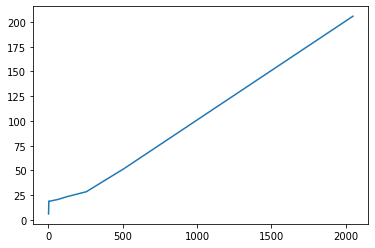

In [9]:
packet_numbers = [2**i for i in range(1,12)]
outputs = np.zeros((len(packet_numbers), max_rand))

for rand_iter in tqdm(range(max_rand)):

    nodes = generate_network(n,r_max)
    A = adjacency_matrix(nodes,tau_max)
    At = disable_links(A,5000,mode="unstable")
    print(A)
    for i in range(len(packet_numbers)):
        packets = np.random.randint(1, n, (packet_numbers[i], 2))
        packets[:,1] = 0

        if rand_iter == 1:
            results = greedy_routing(At, packets, ttr, delta_time)
            arrival_times = np.array([packet.arrival_times[-1] for packet in results])
            outputs[i, rand_iter] = np.max(arrival_times)

arrival_times = np.mean(outputs, axis = 1)
plt.plot(packet_numbers, arrival_times)

In [10]:
#TEST 
#Here we test our function with 3 packets
if(False):
    n_pkts = 3
    T_tx = 0.5
    A=np.zeros((3,3))
    A[0,1] = A[1,0] = 1
    A[1,2] = A[2,1] = 2
    A[0,2] = 3

    scheduling = [[2,4],[1,5.5],[]]
    routing = [[[0,2],[0,1,2]],[[1,2]],[]]

    delay = delay(A, scheduling, routing, n_pkts, T_tx)
    print(delay)

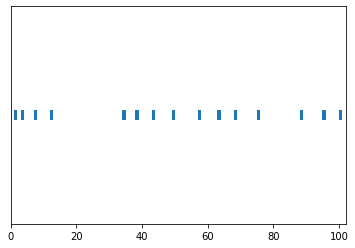

In [11]:
#Test of pkt_plot function
if(True):
    recept_times=[1,3,7,12,34,38,43,49,57,63,68,75,88,95,100]

    t_tx=1
    pkt_plot(recept_times,t_tx)

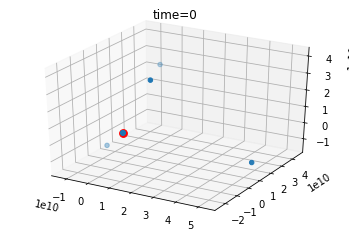

In [12]:
## ANIMATION 1

#enable first line to make the animation work
#WARNING: all other figures will be affected until you restart the kernel

#%matplotlib notebook 

coord = np.copy(nodes)
polar = generate_network(n,r_max,polar=True)

def update_graph(num):

    theta = polar[:,1]
    phi = polar[:,2]
    
    old_r = np.linalg.norm(coord,axis=1)
    
    coord[:,0] += - c*np.cos(theta)*np.sin(phi)
    coord[:,1] += - c*np.sin(theta)*np.sin(phi)
    coord[:,2] += - c*np.cos(phi)
    
    new_r = np.linalg.norm(coord,axis=1)
    
    not_done = new_r < old_r  #this happens after a packet reach Earth

    #coord = coord * not_done.reshape((n,-1))  #sets coordinates of a pkt to 0 if it already reached Earth

    for i in range(n):    # ISSUE: previous line doesn't work, this "for" cycle is a substitute
        if not not_done[i]:
            coord[i,0] = coord[i,1] = coord[i,2] = 0
            
    graph._offsets3d = (coord[:,0],coord[:,1],coord[:,2])
    title.set_text("time={}".format(num))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Pkts')

graph = ax.scatter(coord[:,0],coord[:,1],coord[:,2])
ax.scatter(0,0,0,color="red",s=60)   #Earth

ani = animation.FuncAnimation(fig, update_graph, 
                               interval=50, blit=False)

plt.show()

# EPIDEMIC ALGORITHM

In [13]:
import numpy as np
import math
import pandas as pd

# n_packet = every list is the code of node with the same index, and 
#contains the ID packet that we want to send
# n_node_tot = number of nodes, in our case is 10 including the earth
# packet_trace = keep the trace of the road followed by each package
# trasmision_time = time to trasmit a single packet
# packet_arrive = [ID number of packets arrive to earth]
# packet_arrive_dupl = [ID number of all packets arrive to earth]
# vulnerable_time = [[start_time, finshed_time] collect the vunlerable 
#time for each node]
# slot_time = duration of each interval time
# packet_time = each list rappresent a single packet: the value is the
#time it takes to get to the earth, the index indicates
#               from which node the packet is send to earth.
#propagation_time = matrix that collects the propagation time between
#nodes when the connection is up

#B = disable_links(A,100,mode="light")
n_node_tot = At.shape[0]
n_packet_tot = 13
n_packet = [[],[0,1],[2,3,4],[5,6,7,8],[9],[],[],[10],[11],[12]]
packet_trace = [[],[0,1],[2,3,4],[5,6,7,8],[9],[],[],[10],[11],[12]]
transmission_time = 0.5
packet_arrive = []
vulnerable_time = np.zeros(n_node_tot)
slot_time = 10
packet_time = np.zeros((n_packet_tot, n_node_tot-1))
propagation_time = A
times = {
    "ttx": transmission_time,
    "vulnerable": vulnerable_time,
    "slot": slot_time,
    "packet": packet_time
}
print(At.shape)

#start time
for t in np.arange(0,At.shape[2]*slot_time,0.5):
    for i in range(1, n_node_tot):
        #print('tempo che scorre',t)
        if (np.array(n_packet[i])).size != 0:
            if t != 0:
                for p in n_packet[i]:
                    if packet_time[p, i-1] <= t:
                        packet_time[p, i-1] = packet_time[p, i-1] + 0.5
            
            # if the link to erath is down 
            if not check_link(At, i, 0, t, times):
                if ( (t >= vulnerable_time[i] + transmission_time) == True):
                    
                    times["vulnerable"], n_packet, packet_trace, times["packet"] = add_packet(
                        At,
                        t,
                        i, 
                        times,
                        n_packet,
                        packet_trace
                    )
                    
            else:
                
                if t >= vulnerable_time[i] + transmission_time:
                    
                    #this is all just one line
                    times["vulnerable"], n_packet, packet_trace, packet_arrive, times["packet"] = arrive_to_earth(
                        At,
                        t,
                        i,
                        times,
                        n_packet,
                        packet_trace,
                        packet_arrive
                    )
                    
    if len(n_packet) == 0:
        break


#the set is a data structure that removes all duplicates
print('packet_arrive', set(packet_arrive))
print('packet_arrive_dupl', packet_arrive)
data = pd.DataFrame(packet_time)
data       

(10, 10, 5000)
packet_arrive {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
packet_arrive_dupl [0, 2, 4, 5, 7, 9, 10, 11, 12, 1, 3, 6, 8]


,0,1,2,3,4,5,6,7,8
0,69.322588,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,69.822588,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,65.968784,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,66.968784,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,66.468784,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
5,0.000000,0.000000,182.94625,0.000000,0.0,0.0,0.000000,0.000000,0.000000
6,0.000000,0.000000,183.94625,0.000000,0.0,0.0,0.000000,0.000000,0.000000
7,0.000000,0.000000,183.44625,0.000000,0.0,0.0,0.000000,0.000000,0.000000
8,0.000000,0.000000,184.44625,0.000000,0.0,0.0,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.00000,106.797404,0.0,0.0,0.000000,0.000000,0.000000


# Bibliography

[1] Jain, Sushant, Kevin Fall, and Rabin Patra. "Routing in a delay tolerant network." Proceedings of the 2004 conference on Applications, technologies, architectures, and protocols for computer communications. 2004.

In [14]:
###deviations: given an optimal routing (that in our case is the one determined by Dijkstra) this function returns 
#the fraction of times a packet doesn't follow the route which was pre-established by the algorithm
def deviations(optimal,routing,n_pkts):
    dev = 0
    for node in routing:
        dev = dev + sum([1 for path in node if path != optimal[path[0]][path[-1]]])
    return dev/n_pkts

In [15]:
#TEST of deviations function

#optimal = [[[0,0],[0,1],[0,2]],[[1,0],[1,1],[1,2]],[[2,0],[2,1],[2,2]]]  
#dev = deviations(optimal,routing,3)
#print(dev)

In [16]:
#TEST throughput using the delay function
#throughput(n_pkts,delay)

# Bibliography

[1] Jain, Sushant, Kevin Fall, and Rabin Patra. "Routing in a delay tolerant network." Proceedings of the 2004 conference on Applications, technologies, architectures, and protocols for computer communications. 2004.